## Import libraries

In [3]:
pip install pydub

In [4]:
pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=7e39c8a05aa66ddd40fe2aa6bdee5a0908b7799434dd1f231e8b0920530913d5
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [5]:
import os
import zipfile
import pandas as pd
from glob import glob
import pickle
from pydub import AudioSegment
from scipy.io import wavfile as wav
import IPython.display as ipd
from matplotlib import pyplot as plt
import random
import re
import wave

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score
from keras.callbacks import Callback
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from collections import Counter

In [6]:
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)
tf.random.uniform(shape=(1,), seed=123)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7995876], dtype=float32)>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following code snippet must be run only once, as it is creating a new folder and converting all the *.mp3* files into *.wav* files.

In [ ]:
file_path = "/content/drive/MyDrive/Digital Signal and Image Management/accent_archive/recordings/recordings/"
new_path = "/content/drive/MyDrive/Digital Signal and Image Management/accent_archive/recordings/wav/"

In [ ]:
for file in os.listdir(file_path):
  if file.endswith(".mp3"):
    mp3_path = os.path.join(file_path, file)
    wav_path = os.path.join(new_path, file[:-4] + '.wav')
    sound = AudioSegment.from_mp3(mp3_path)
    sound.export(wav_path, format="wav")

## Data processing on a single file

In [39]:
random_audio = random.choice(os.listdir(new_path))
sound_rate, sound_data = wav.read(new_path + random_audio)
ipd.Audio(sound_data, rate=sound_rate)


Output hidden; open in https://colab.research.google.com to view.

In [32]:
print(f"The name of the file is: {random_audio}")

The name of the file is: russian10.wav


In [33]:
regular = re.match("(\D+)\d+\.wav", random_audio)
regular.group(1)

'russian'

#### Visual representation of the audio

In [40]:
print(f"The sample rate of the file is: {sound_rate}")
print(f"The size of the signal is: {sound_data.shape[0]}")
sound_time = np.arange(sound_data.shape[0] * 1.0) / sound_rate
print("The length in seconds is: {:.2f}s".format(sound_time[-1]))

The sample rate of the file is: 44100
The size of the signal is: 1518706
The length in seconds is: 34.44s


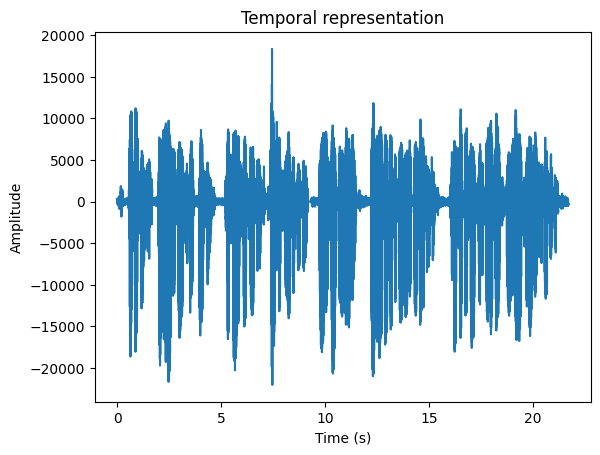

In [11]:
plt.plot(sound_time, sound_data);
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Temporal representation')
plt.show()

The sample rate is always 44100 and the average duration of the audio heavily depends on the person and its native language.

### Cepstral Representation (MFCC)

In [12]:
mfccs = scale(mfcc(y=sound_data*1.0, sr=sound_rate), axis=1)
# Shape of the resulting MFCC matrix
mfccs.shape

(20, 2034)

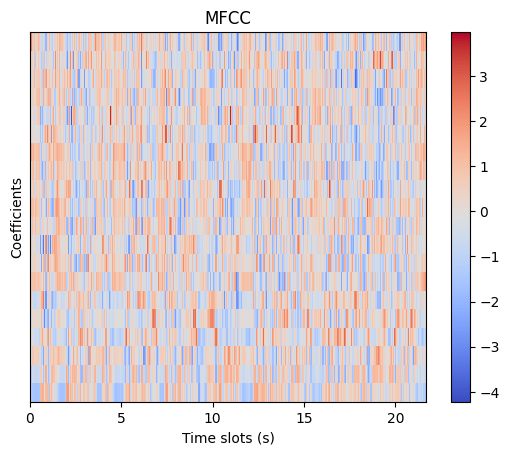

In [13]:
# Visualization via librosa's specshow
specshow(mfccs, sr=sound_rate, x_axis='time')
plt.xlabel('Time slots (s)')
plt.ylabel('Coefficients')
plt.title('MFCC')
plt.colorbar()
plt.show()

## Data Loading

In [14]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir(new_path)):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            sr, signal = wav.read(new_path + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            matches = re.match("(\D+)\d+\.wav", f)
            nationality = matches.group(1)
            labels.append(nationality)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels)

    return X_train, X_test, y_train, y_test

In [15]:
max_length=4000 # number of maximum columns

In [16]:
def feats_mfcc_padded(input, rate=sound_rate, tsize=max_length):
    output = scale(mfcc(y=input*1.0, sr=rate))
    output = output[:,:tsize]

    zeros = np.zeros((output.shape[0], tsize-output.shape[1] ))
    padded = np.concatenate((output, zeros), axis=1)
    return padded

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc_padded)

In [ ]:
df_train = pd.DataFrame({'mfcc' : X_train, 'labels' : y_train})
df_test = pd.DataFrame({'mfcc' : X_test, 'labels' : y_test})

df_train.head()

### Save data externally

In [10]:
drive_path = '/content/drive/MyDrive/Digital Signal and Image Management/accent_archive/recordings/'

In [ ]:
df_train.to_pickle(drive_path + 'mfcc_padded_train.pkl')
df_test.to_pickle(drive_path + 'mfcc_padded_test.pkl')

### Import data

In [ ]:
drive_path = '/content/drive/MyDrive/Digital Signal and Image Management/accent_archive/recordings/'

In [11]:
max_length=4000 # number of maximum columns

In [12]:
df_train = pd.read_pickle(drive_path + 'mfcc_padded_train.pkl')
df_test = pd.read_pickle(drive_path + 'mfcc_padded_test.pkl')

In [27]:
labels = df_test['labels'].append(df_train['labels']).unique()

with open(drive_path + 'labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

<ipython-input-27-52d2913c9ff9>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labels = df_test['labels'].append(df_train['labels']).unique()


In [ ]:
train_pcg = np.sum(df_train['labels'].apply(lambda x: 1 if x=='english' else 0))/df_train.shape[0]
print('Positive class on train set: {:.2f}%'.format(train_pcg*100))

Positive class on train set: 26.78%


In [ ]:
test_pcg = np.sum(df_test['labels'].apply(lambda x: 1 if x=='english' else 0))/df_test.shape[0]
print('Positive class on test set: {:.2f}%'.format(test_pcg*100))

Positive class on test set: 28.27%


The percentage of positive class in train and test splits is rather similar, although stratified sampling was not initially applied in the loaded Dataframes.

In [11]:
df_train['labels'] = df_train['labels'].apply(lambda x: 1 if x=='english' else 0)
df_test['labels'] = df_test['labels'].apply(lambda x: 1 if x=='english' else 0)

We change the labels according to a **binary classification** problem, where **1** indicates English **native speakers** and **0** stands for **foreign speakers**.

## OVERSAMPLING

In [12]:
english_speakers = np.sum(df_train['labels'])
english_speakers

458

In [ ]:
print('Percentage of English speakers: {:.2f}%'.format(english_speakers / len(df_train['labels']) * 100))

Percentage of English speakers: 26.78%


In [13]:
oversample_ratio = (len(df_train['labels']) - english_speakers) / english_speakers
oversample_ratio

2.7336244541484715

In [17]:
    def oversample(X_train_std, y_train, target_size, ratio):
        X_train = np.array(X_train_std).reshape(-1, 20, target_size)
        y_train = np.array(y_train).reshape(-1, 1)
        temp = pd.DataFrame({'mfcc_id':range(X_train.shape[0]), 'labels':y_train.reshape(-1)})
        temp_eng = temp[temp['labels']==1]
        temp_non_eng = temp[temp['labels']==0]
        idx = list(temp_eng['mfcc_id']) * ratio
        idx = idx + list(temp_non_eng['mfcc_id'])


        X_train = (X_train[idx]).reshape(-1, 20, target_size)
        y_train = np.ones(458*ratio).reshape(-1,1)
        y_train = np.vstack((y_train, np.zeros(1252).reshape(-1,1)))

        return X_train, y_train

In [18]:
X_train, y_train = oversample(list(df_train['mfcc']), list(df_train['labels']), max_length, round(oversample_ratio))

(2626, 20, 4000)
(2626, 1)


In [19]:
with open(drive_path + 'mfcc_oversampled_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

with open(drive_path + 'labels_oversampled_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)


In [96]:
X_train = np.load(drive_path + 'mfcc_oversampled_train.pkl', allow_pickle=True)
y_train = np.load(drive_path + 'labels_oversampled_train.pkl', allow_pickle=True)

# Modeling

## Convolutional Neural Network

In [22]:
X_test = np.array(list(df_test['mfcc']))
y_test = df_test['labels']

In [23]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 20, max_length, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 20, max_length, 1)

In [ ]:
# Best so far
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=(20, max_length, 1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))

model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy', keras.metrics.Recall()])

In [ ]:
callbacks = [EarlyStopping(patience=5)]

In [ ]:
history = model.fit(X_train_reshaped, y_train, batch_size=128, epochs=40, verbose=1, callbacks = callbacks,
            validation_data=(X_test_reshaped, y_test))

Epoch 1/40
21/21 [==============================] - 405s 19s/step - loss: 0.6373 - accuracy: 0.6512 - recall: 0.6914 - val_loss: 0.6224 - val_accuracy: 0.6355 - val_recall: 0.8099
Epoch 2/40
21/21 [==============================] - 398s 19s/step - loss: 0.5766 - accuracy: 0.7060 - recall: 0.7948 - val_loss: 0.6272 - val_accuracy: 0.6425 - val_recall: 0.8017
Epoch 3/40
21/21 [==============================] - 403s 19s/step - loss: 0.5718 - accuracy: 0.7201 - recall: 0.8035 - val_loss: 0.6007 - val_accuracy: 0.6589 - val_recall: 0.7603
Epoch 4/40
21/21 [==============================] - 405s 19s/step - loss: 0.5682 - accuracy: 0.7167 - recall: 0.7904 - val_loss: 0.5962 - val_accuracy: 0.6706 - val_recall: 0.7521
Epoch 5/40
21/21 [==============================] - 401s 19s/step - loss: 0.5680 - accuracy: 0.7159 - recall: 0.7700 - val_loss: 0.5888 - val_accuracy: 0.6729 - val_recall: 0.7603
Epoch 6/40
21/21 [==============================] - 409s 19s/step - loss: 0.5681 - accuracy: 0.7152 

In [ ]:
model.save(drive_path + 'cnn_model_final')

### Load the stored model

In [97]:
model = load_model(drive_path + 'cnn_model_final')

In [29]:
logits = model.predict(X_test_reshaped)
y_pred = [1 if x>0.5 else 0 for x in logits]

14/14 [==============================] - 15s 1s/step


In [31]:
from collections import Counter

# Count the occurrences of each value
value_counts = Counter(y_pred)

# Print the counts
for value, count in value_counts.items():
    print(f"{value}: {count}")

0: 267
1: 161


The model accuracy is not evolving after a few epochs because it is always predicting the majority class, as the dataset is unbalanced.

We must perform **oversampling** to make the positive instances as frequent as the negative ones.

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       307
           1       0.50      0.67      0.57       121

    accuracy                           0.72       428
   macro avg       0.68      0.70      0.68       428
weighted avg       0.75      0.72      0.73       428



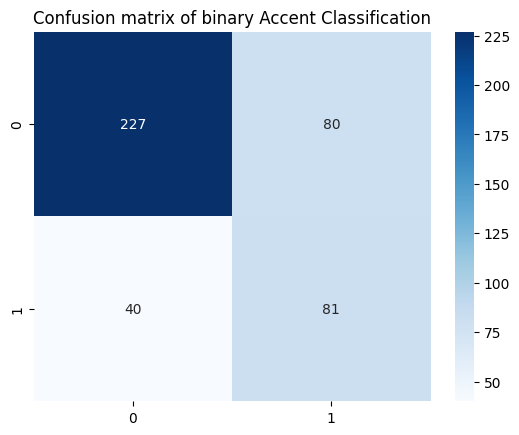

In [100]:
cf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion matrix of binary Accent Classification')
ax.set_xlabel = 'Predicted values'
ax.set_ylabel = 'Actual values'

ax.xaxis.set_ticklabels=(['False', 'True'])
ax.yaxis.set_ticklabels=(['False', 'True'])

plt.show()

We can see that althout the average metrics exhibit good results, the minority positive class (native English speakers) are correctly identified only around 50% of the times.

#### ROC-AUC Curve

In [101]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, logits)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)

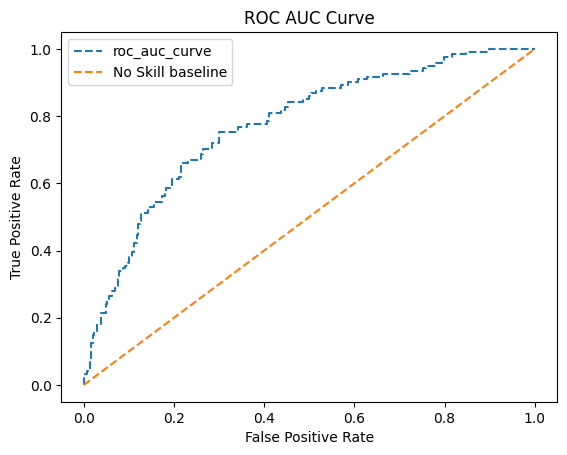

In [102]:
plt.plot(fpr, tpr, linestyle='--', label='roc_auc_curve')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.title('ROC AUC Curve')
plt.show()

#### Model Architecture

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 3999, 32)      160       
                                                                 
 activation (Activation)     (None, 19, 3999, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 3998, 32)      4128      
                                                                 
 activation_1 (Activation)   (None, 18, 3998, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 1999, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 9, 1999, 32)       0         
                                                        